In [93]:
#data handling
import pandas as pd

#chatgpt
from openai import OpenAI

#hf
from transformers import AutoTokenizer
from huggingface_hub import InferenceClient
from transformers import pipeline


#prompts and processing
from chat2Vis import format_response,format_question,get_primer

#image handling
import io
import base64
from IPython import display
import matplotlib.pyplot as plt


#misc
from dotenv import dotenv_values
import concurrent.futures
import hashlib
from random import randint
from time import sleep


# Chat Set Up

In [2]:
#useful because your don't need to read in the CSV data, makes things a little easier
df = pd.read_csv('workspace/Titanic-Dataset.csv')

In [3]:
#setting up the same system prompts as Chat2VIS
primer_desc, primer_code = get_primer(df,'./workspace/Titanic-Dataset.csv')

chat = [
  {"role": "system", "content": primer_desc}
]

In [4]:
chat

[{'role': 'system',
  'content': "Use a dataframe called df from './workspace/Titanic-Dataset.csv' with columns 'PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked'. \nThe column 'PassengerId' is type int64 and contains numeric values. \nThe column 'Survived' is type int64 and contains numeric values. \nThe column 'Pclass' is type int64 and contains numeric values. \nThe column 'Sex' has categorical values 'male','female'. \nThe column 'Age' is type float64 and contains numeric values. \nThe column 'SibSp' is type int64 and contains numeric values. \nThe column 'Parch' is type int64 and contains numeric values. \nThe column 'Fare' is type float64 and contains numeric values. \nThe column 'Embarked' has categorical values 'S','C','Q','nan'. \nLabel the x and y axes appropriately.\nAdd a title. Set the fig suptitle as empty.{}\nUsing Python version 3.9.12, create a script, the script should only include code, no comments, using the dataf

# LLM Setup

In [5]:
#basic test converations
convo_hist = chat
convo_hist.append({'role':"user", "content":"show chart of total number of people surviving vs not surviving"})

In [6]:
convo_hist

[{'role': 'system',
  'content': "Use a dataframe called df from './workspace/Titanic-Dataset.csv' with columns 'PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked'. \nThe column 'PassengerId' is type int64 and contains numeric values. \nThe column 'Survived' is type int64 and contains numeric values. \nThe column 'Pclass' is type int64 and contains numeric values. \nThe column 'Sex' has categorical values 'male','female'. \nThe column 'Age' is type float64 and contains numeric values. \nThe column 'SibSp' is type int64 and contains numeric values. \nThe column 'Parch' is type int64 and contains numeric values. \nThe column 'Fare' is type float64 and contains numeric values. \nThe column 'Embarked' has categorical values 'S','C','Q','nan'. \nLabel the x and y axes appropriately.\nAdd a title. Set the fig suptitle as empty.{}\nUsing Python version 3.9.12, create a script, the script should only include code, no comments, using the dataf

## API Access

This code requires that you have:

* Set up your own OpenAI and Hugging Face Tokens 
* Set up the [hugging face inference endpoint](https://huggingface.co/blog/inference-endpoints-llm) and have a url that you point it to

If you have neither of those, this code will not run. You can run and set up Code LLama on your own machines if you want, it just takes a lot of compute to set up and run the Code LLama 34b parameter model - the inference endpoints might be best. That endpoint cost $4.50/hr currently, you can run the 7 billion parameter model for less (and even a high-end laptop), but the results aren't as good.


In [34]:
config = dotenv_values(".env")


### ChatGPT

In [8]:
client = OpenAI(
    api_key=config['OPENAI_API_KEY']
)

def call_openai(model='gpt-3.5-turbo', messages=None):
    completion = client.chat.completions.create(
        model = model,
        messages = messages
    )
    return(completion)

In [87]:
#test call
gpt_ans= call_openai(messages=convo_hist)
gpt_ans = gpt_ans.choices[0].message.content

In [90]:
def to_png_string(code):
    buf = io.BytesIO()
    exec(code)
    plt.savefig(buf, format='png')
    png_string = base64.b64encode(buf.getvalue()).decode('utf-8')
    buf.close()

    return png_string


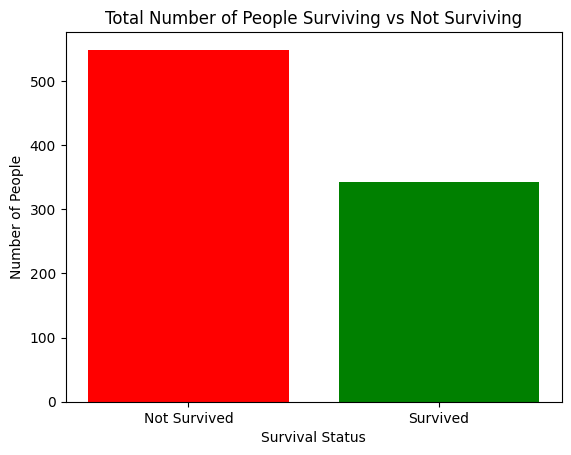

<Figure size 640x480 with 0 Axes>

In [95]:
img  = to_png_string(gpt_ans)

#### ChatGPT Assistants API test

**This is a new feature which can explicitly use code interpreter, relative to the standard ChatGPT API.**


You only need to do this once, afterwards, you just provide the assistant id, which can be stored in a .env file

``` Python
file = client.files.create(
  file=open("./workspace/Titanic-Dataset.csv", "rb"),
  purpose='assistants'
)


assistant = client.beta.assistants.create(
    name="VA Chat",
    instructions="You are a visual analytics assistant. You will create data visualizations that generate visualizations based on user input.",
    tools=[{"type": "code_interpreter"}],
    model="gpt-4-1106-preview",
    file_ids=[file.id]
)
```

In [85]:
#create a slightly modified primer description for the assistant
primer_desc_mod= f"Using Python version 3.9.12, create and return script responding to the user's query. The script should only include code, no comments, using a dataframe called df to graph the following"

In [79]:
#initialze conversation
thread = client.beta.threads.create()
a_id = config['ASSISTANT_ID']


In [80]:

def add_assistant_msg(message,thread_id):
    #assumes that message is a dictionary containing the role and content
    message = client.beta.threads.messages.create(
        thread_id=thread_id,
        role=message['role'],
        content=message['content']
    )
    return(message)

def run_openai_assistant(message,thread_id,a_id,primer_desc_mod):
  
    #add new message to thread
    message = add_assistant_msg(message,thread_id)

    #create the run
    run = client.beta.threads.runs.create(
        thread_id=thread_id,
        assistant_id=a_id,
        instructions=primer_desc_mod
        )

    #get the response
    complete = False
    while not complete:
        run = client.beta.threads.runs.retrieve(
        thread_id=thread_id,
        run_id=run.id
        )
        if run.status == "completed":
            complete = True
        elif run.status not in ["in_progress","queued"]:
            raise Exception("Response failed to return")       
        else:
            sleep(1)

    #now that it is complete, get the message responses:
    messages = client.beta.threads.messages.list(thread_id=thread_id)  

    #code interpreter will provide an image file (latest file is always index 0)
    image=client.files.content(messages.data[0].content[0].image_file.file_id)  

    #return the message history and the content
    return messages, image.content


In [81]:
message = {
    "role": "user",
    "content": "show chart of total number of people surviving vs not surviving"
}
messages, image= run_openai_assistant(message,thread.id,a_id,primer_desc_mod)

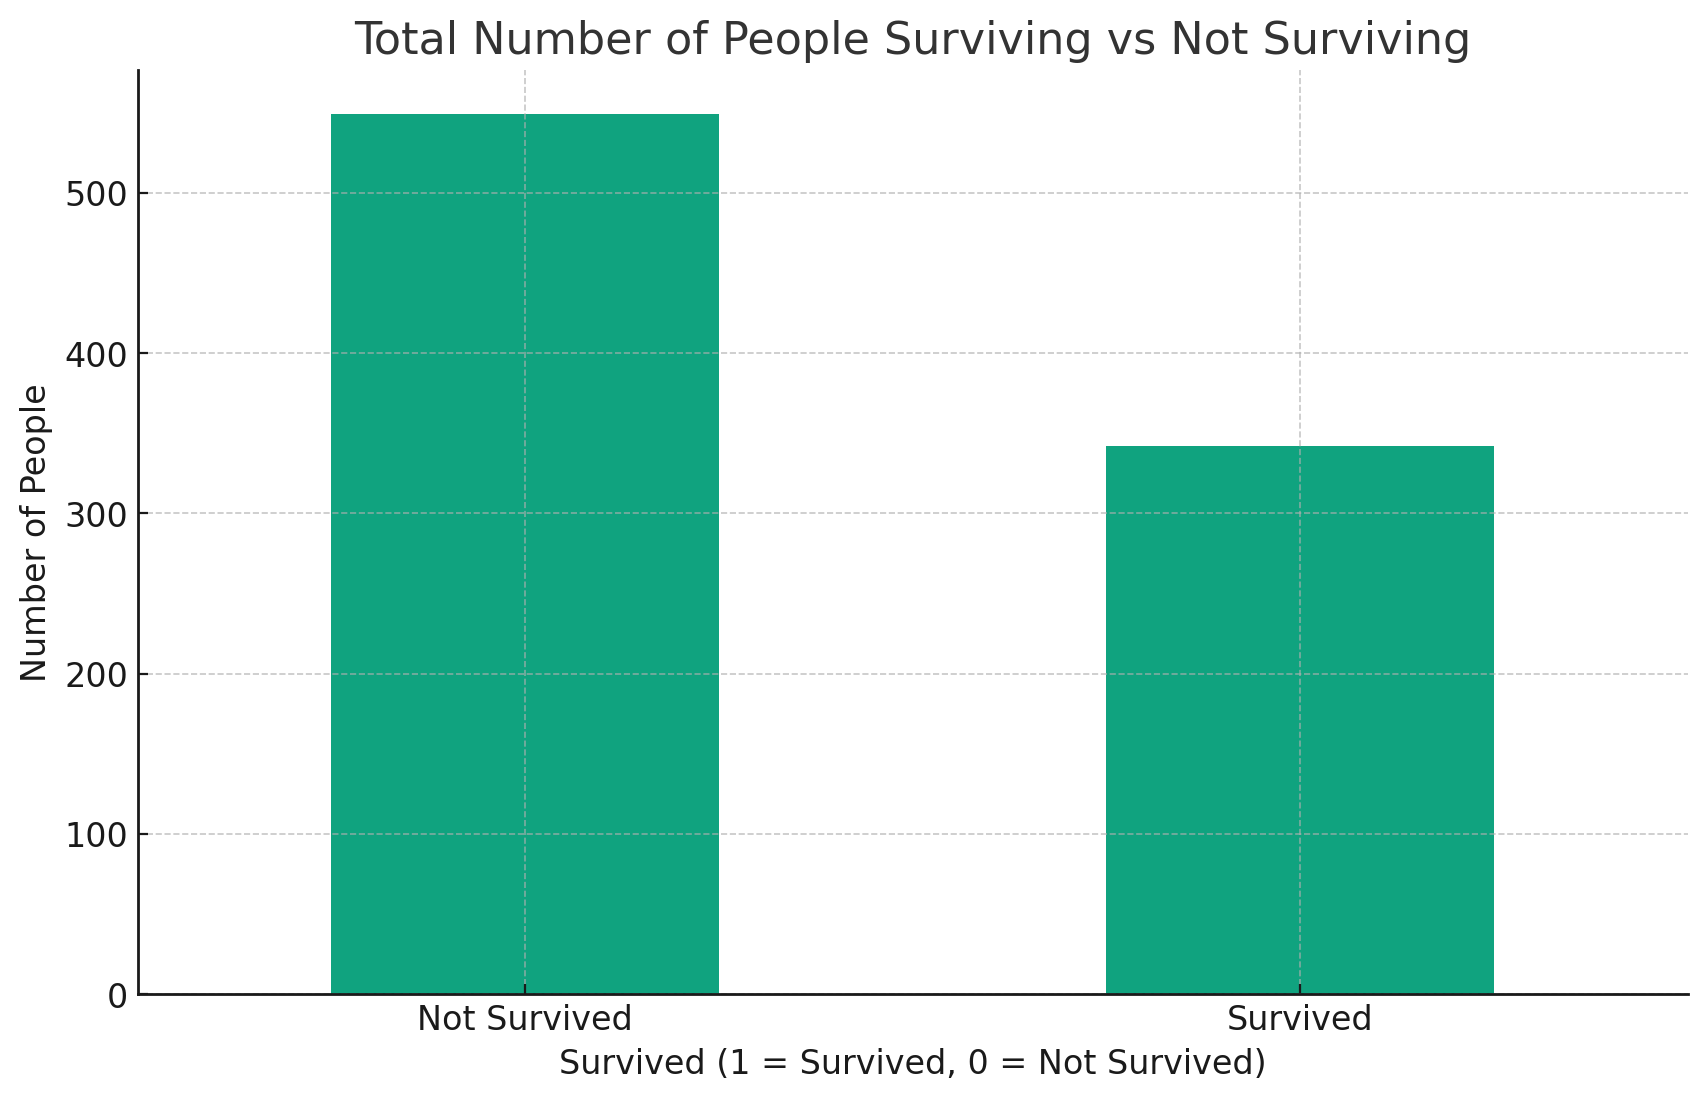

In [82]:
display.Image(image,width = 250, height = 250)

In [83]:
#adding a new conversation item
message = {
    "role": "user",
    "content": "show age bins"
}

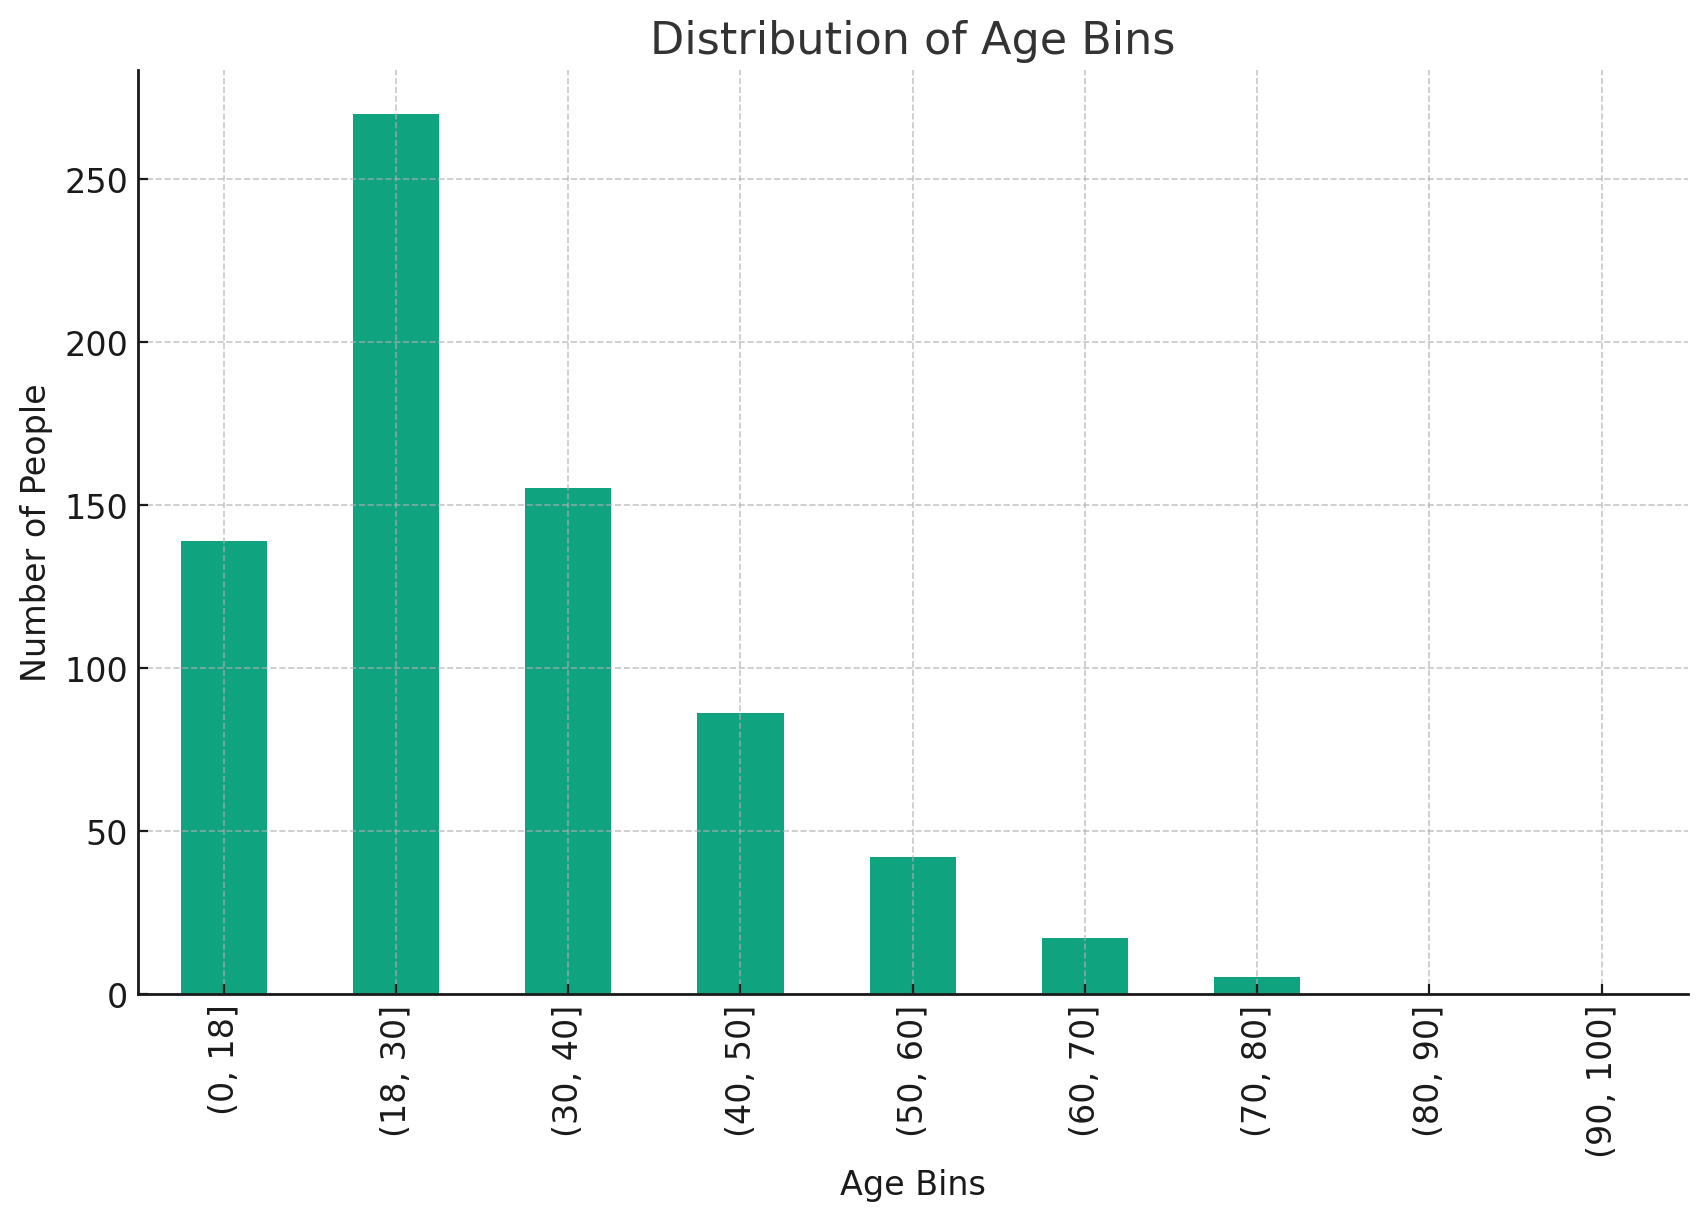

In [84]:
# This is a good example that the assistant creates a totally new image, and does not add the context for the prior chart (e.g. survival) to the new chart (e.g. age bins)
messages, image= run_openai_assistant(message,thread.id,a_id,primer_desc_mod)
display.Image(image,width = 250, height = 250)

**To give open ai an honest shot, lets see if it works with a modified primer telling it what to do**

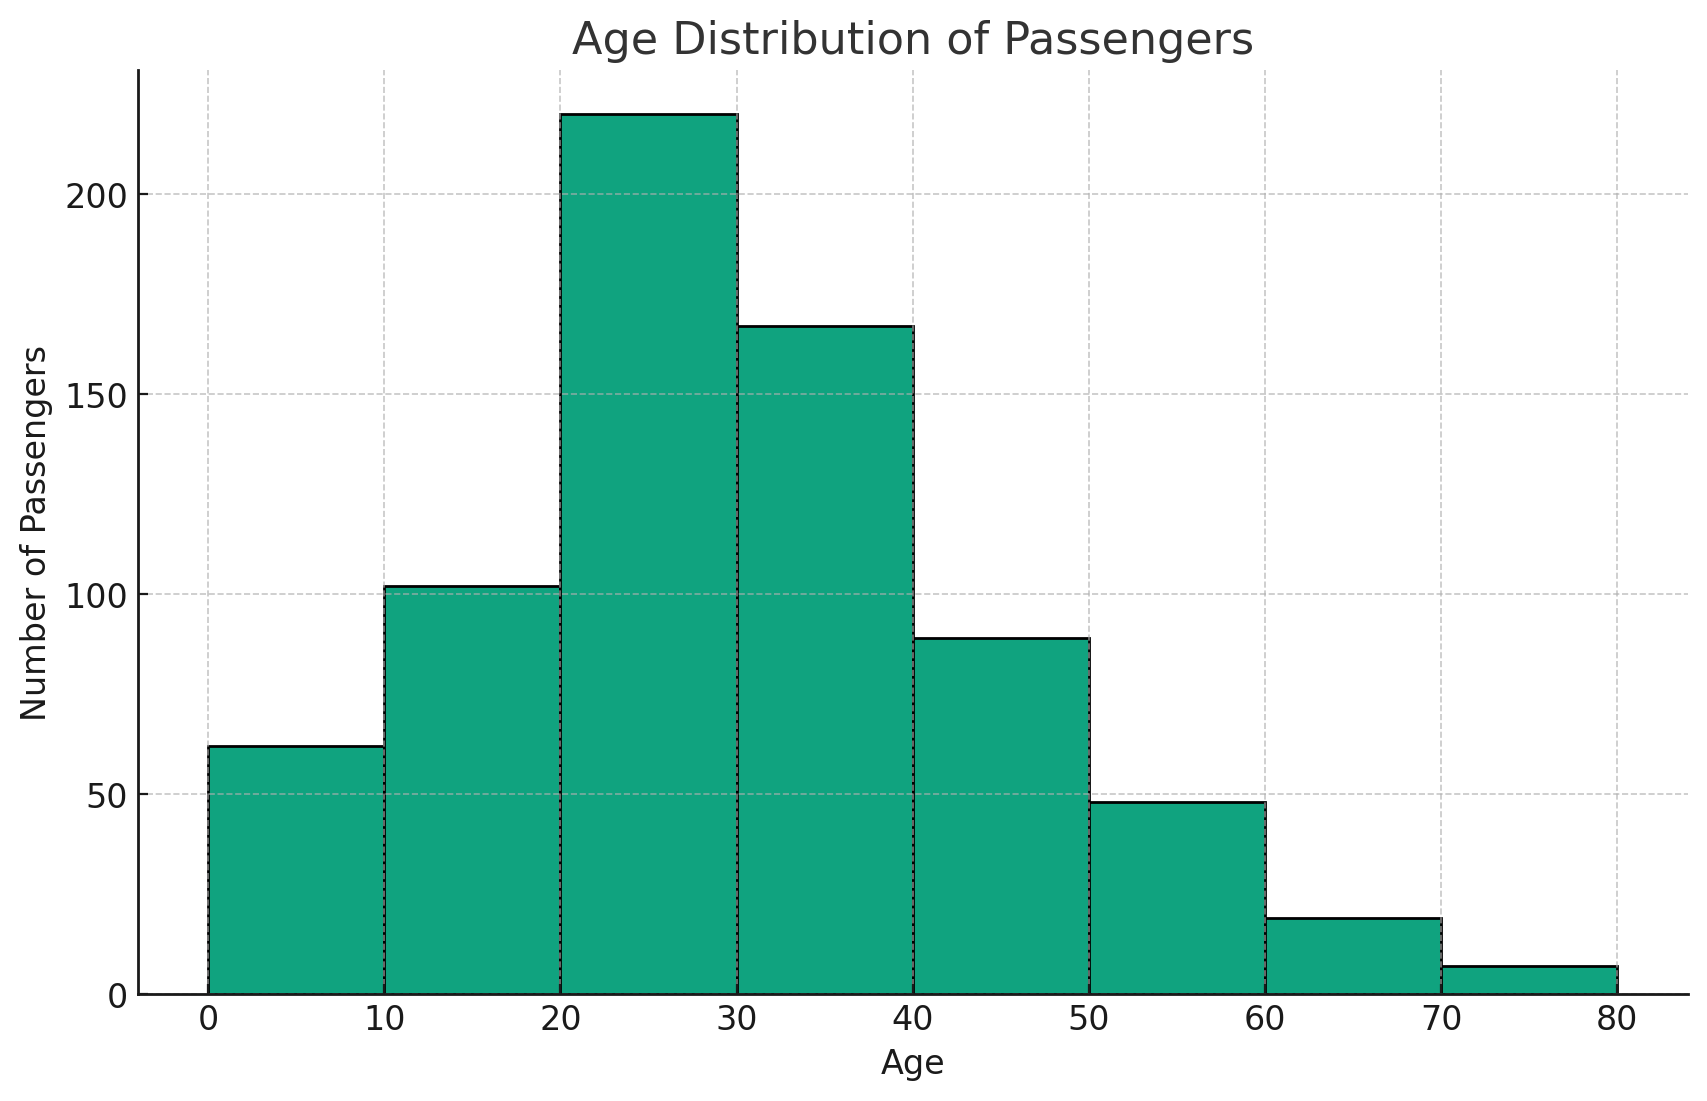

In [86]:
primer_desc_mod_content= f"Using Python version 3.9.12, create and return script responding to the user's query. The script should only include code, no comments, using a dataframe called df to graph the following. Unless the user enters a phrase like `start over', `rest' or `clear' retain the context prior the prior messages when updating the visualization. Otherwise, start a brand new data visualization."

#initialze conversation
thread = client.beta.threads.create()
a_id = config['ASSISTANT_ID']

#... message one
message = {
    "role": "user",
    "content": "show chart of total number of people surviving vs not surviving"
}
messages, image_1= run_openai_assistant(message,thread.id,a_id,primer_desc_mod)

#... message two
message = {
    "role": "user",
    "content": "show age bins"
}

messages, image_two= run_openai_assistant(message,thread.id,a_id,primer_desc_mod)
display.Image(image_two,width = 250, height = 250)

Even with this modified prompt the open ai assistant DOES NOT include the survival variable (e.g., it does not retain the context of the prior chart). **This is using the latest GPT-4 model**

### Code LLAMA

In [ ]:
def setup_codellama(model_size="7B"):
    # HF Inference Endpoints parameter
    endpoint_url = config['CL_7B']

    if model_size == "34B":
        endpoint_url = config['34_7B']


    # Streaming Client
    # ** warning - do no call the hf client, 'client' or it will inferfere with the openai client
    hf_inf = InferenceClient(endpoint_url, token=config['HF_API_KEY'])

    # generation parameter
    gen_kwargs = dict(
        max_new_tokens=512,
        top_k=30,
        top_p=0.9,
        temperature=0.2,
        repetition_penalty=1.02,
    )

    return hf_inf, gen_kwargs

def format_prompt(convo,primer = None):

    if(primer is not None):
        #need to remind code llama to write out
        #code each time :/
        idx = len(convo)-1
        convo[idx]['content'] = primer + convo[idx]['content']
        
    #preping the prompt for Code LLama
    tokenizer = AutoTokenizer.from_pretrained("codellama/CodeLlama-7b-Instruct-hf",token=config['HF_API_KEY'])
    tokenizer.use_default_system_prompt = False
    prompt = tokenizer.apply_chat_template(convo, tokenize=False)

    return prompt

def call_codellama(convo,hf_inf,gen_kwargs,primer=None):
    #calling Code LLama
    prompt = format_prompt(convo,primer)
    stream = hf_inf.text_generation(prompt, stream=False, details=True, **gen_kwargs)
    response = primer_code + format_response(stream.generated_text.strip())

    #try execute the response a maximum of twice if the code doesn't run
    '''
    try:
        ans=exec(response)
    except:
        if attempt ==3:
            response = "ERROR: FAILED TO EXECUTE CODE"
        else:
            attempt+=1
            response = call_codellama(convo,client,gen_kwargs,attempt)
    '''
    
    return response

In [ ]:
hf_inf, gen_kwargs = setup_codellama(convo_hist)
cl_ans = call_codellama(convo_hist,hf_inf,gen_kwargs)

In [ ]:
#plot the answer
# Note: the 7B Code LLama model is usually very wrong - its good for testing, but not as good for actual results
img = to_png_string(cl_ans)

# Conversations

In [ ]:
convos = pd.read_csv('workspace/utterances.csv')

In [ ]:
def get_hash(x):
    rn = str(randint(0, 100))
    return(hashlib.md5(f"{x['PID']}-{x['Utterance']}-{rn}".encode('utf-8')).hexdigest())


pids = convos['PID'].unique()

convos['utt_id']=convos.apply(lambda x: get_hash(x), axis=1)
convos[convos['PID'] == 'P03']

In [ ]:
class analytic_conversation:
    def __init__(self,pid,history=[]):
        self.pid = pid
        self.history = history
    
    def add_utterance(self,utterance,utt_id):
        utterance = [{'role':'user','model': '', 'content':utterance,'utt_id':utt_id}]
        self.history+= utterance

    
    def add_response(self,utt_id,responses):
        '''
        responses should be a dictionary object where:
        * each key is a model containing
        * the code it executed 
        '''        
        assistant_resp = []

        for key in responses.keys():
            tmp = [{'role':'assistant','model': key, 'content':responses[key],'utt_id':utt_id}]
            assistant_resp +=tmp
            
        self.history+= assistant_resp
    
    def return_filtered_history(self, model_type=''):
        ''' return the chat history filtered by a specific model'''

        if model_type == '':
            return(self.history)
        
        filtered_conversation = []
        for item in self.history:
            if item['role'] in ['user','system']:
                filtered_conversation+=[{'role':item['role'],'content':item['content']}]
            elif item['role'] == 'assistant':
                if item['model'] == model_type:
                    filtered_conversation+=[{'role':item['role'],'content':item['content']}]

        return(filtered_conversation)
    
    def to_df(self):
        return(pd.DataFrame(self.history))
    
    def __repr__(self):
        return(f"Analytic Conversation for PID: {self.pid}")



**Example / Sanity Check : One Participant**

In [ ]:
#run gpt and code-llama models, store the results
sys={"role": "system", "model":'',"content": primer_desc}

#filter conversation
pid='P03'

sub_convo = convos[convos['PID']==pid]
new_convo = analytic_conversation(pid,[sys])

#add a new utterance
new_convo.add_utterance(sub_convo.iloc[0]['Utterance'],sub_convo.iloc[0]['utt_id'])

#get model responses
with concurrent.futures.ThreadPoolExecutor() as executor:
    future = executor.submit(call_openai, 'gpt-3.5-turbo',new_convo.return_filtered_history('gpt3'))
    gpt_ans = future.result()

    future = executor.submit(call_codellama, new_convo.return_filtered_history('cl'),hf_inf,gen_kwargs,primer_desc)
    cl_ans = future.result()

responses = {'gpt3':gpt_ans.choices[0].message.content,'cl':cl_ans}

In [ ]:
exec(cl_ans)

In [ ]:
#add responses
new_convo.add_response(sub_convo.iloc[0]['utt_id'],responses)
new_convo.history

In [ ]:
#get model responses WITH follow-up conversation
new_convo.add_utterance(sub_convo.iloc[1]['Utterance'],sub_convo.iloc[1]['utt_id'])

with concurrent.futures.ThreadPoolExecutor() as executor:
    future = executor.submit(call_openai, 'gpt-3.5-turbo',new_convo.return_filtered_history('gpt3'))
    gpt_ans = future.result()

    future = executor.submit(call_codellama, new_convo.return_filtered_history('cl'),hf_inf,gen_kwargs)
    cl_ans = future.result()

In [ ]:
responses = {'gpt3':gpt_ans.choices[0].message.content,'cl':cl_ans}
new_convo.add_response(sub_convo.iloc[1]['utt_id'],responses)
new_convo.history

In [ ]:
new_convo.return_filtered_history('gpt3')

**ALL Participants**

In [ ]:
#run gpt and code-llama models, store the results
sys={"role": "system", "model":'',"content": primer_desc}

#filter conversation
for pid in pids[:1]:
    count = 0;
    sub_convo = convos[convos['PID']==pid]
    new_convo = analytic_conversation(pid,[sys])

    grouped = sub_convo.groupby('Chunk')
    for chunk, group in grouped:
        for utt,utt_id in group[['Utterance','utt_id']].values.tolist():       
            #add new utterance
            new_convo.add_utterance(utt,utt_id)
            
            #get language model results
            with concurrent.futures.ThreadPoolExecutor() as executor:
                #gpt3
                future = executor.submit(call_openai, 'gpt-3.5-turbo',new_convo.return_filtered_history('gpt3'))
                gpt_ans = future.result()

                #code-llama
                future2 = executor.submit(call_codellama, new_convo.return_filtered_history('cl'),hf_inf,gen_kwargs)
                cl_ans = future2.result()
            
            #add responses to conversation history
            responses = {
                'gpt3':gpt_ans.choices[0].message.content,
                'cl':cl_ans
                }
            new_convo.add_response(sub_convo.iloc[1]['utt_id'],responses)

        #test breaker
        count+=1
        if count == 1:
            break

    all_df = pd.merge(sub_convo,new_convo.to_df(),on='utt_id',how='inner')
    #all_df.to_pickle(f'workspace/convos/{pid}_analytic_convo.pkl')

In [ ]:
all_df